In [1]:
import synapseclient
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import matplotlib as mpl
import scipy.stats as stats
from collections import Counter as c
import sparklines

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
mpl.rcParams['figure.figsize'] = (15.0, 8.0)
mpl.rc('font', **{'family' : 'Arial','size'   : 14})


syn = synapseclient.login()

## Callibration study data
hr_data_entity_id = 'syn17973172'
metadata_entity_id = 'syn17009128'
skin_tone_id = 'syn18082209'
phone_metrics_id ='syn18456060'
spectrocolorimetry_entity_id = 'syn21525189'

## Validation study data
EPARC_DATA = 'syn12257142'
MERGED_HR_FILE_IDS = {'tecumseh':'syn12612345', 'stress_test':'syn12612346', '12MT':'syn12612344', }
ACTIVITY_TABLE_IDS = {'12MT':'syn11665074', 'tecumseh':'syn11432994', 'stress_test':'syn11580624'}
VO2MAX_TECUMSEH_FILE_ID = 'syn14746485'
COMPUTED_DISTANCES_ID = 'syn15382305'
FITZPATRICK_FILE_ID = 'syn15343217'
QUERY = "SELECT * FROM %s where externalId like 'PMI%%'"
phone_prices = {'Huawei Mate SE':'$230',
                'LG Stylo 4':'$249',
                'Moto G6 Play':'$149',
                'Samsung Galaxy J7':'$99',
                'Samsung Galaxy S9+':'$700',
                'iPhone8+':'$349',
                'iPhoneSE':'$149',
                'iPhoneXS':'$999'
               }
CONF_CUTOFF = 0.5

Welcome, Larsson Omberg!



## Plottting functions and helper functions

In [2]:
def plot_bland_altman(x,y, c=None, xlabel='average in values', ylabel='difference in values'):
    """given measurements for x and y plots difference vs average with standard deviation lines. """
    diff_vals = x-y
    avg_vals = (x+y)/2.
    plt.scatter(avg_vals, diff_vals, c=c)
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean(),diff_vals.mean()], 'k')
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean()+diff_vals.std(),diff_vals.mean()+diff_vals.std()], 'r')
    plt.plot([min(avg_vals), max(avg_vals)], [diff_vals.mean()-diff_vals.std(),diff_vals.mean()-diff_vals.std()], 'r')
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    
def ccc(x,y):
    """Computes the correlation between  two values.
    Returns the correlation coefficient"""
    if len(x)==0:
        return np.NaN
    covar = np.cov(x,y, bias=False)[0][1]*(len(x)-1)/float(len(x)) 
    xvar = np.var(x, ddof=1)*(len(x)-1)/float(len(x)) 
    yvar = np.var(y, ddof=1)*(len(y)-1)/float(len(y))
    return (2 * covar) / ((xvar+yvar) +((np.mean(x)-np.mean(y))**2))
    #corr = stats.pearsonr(x, y)
    #return corr[0]

def shakey(r):
    if r.Sex=='Male':
        val= 3.744*(r['Lab Day Wt (kg)']+5)/(64.83-62+.662*r.hb15to30)
    else:
        val = 3.75*(r['Lab Day Wt (kg)']-3)/(51.33-65+0.75*r.hb15to30)
    return val*r.weight/1000 if val>0 else np.nan

def milligan1(HB30to60s, age):
    return (84.687 - 0.722*HB30to60s - 0.383*age)

def milligan2(HB30to60s, age, sex):
    return  83.477 - 0.586*HB30to60s - 0.404*age - 7.030*(sex=='Female')

# Load and transform Data
## Load Calibration Metadata
Load data from multiple data sources and print demographics and summary plots for skin and devices

In [3]:
# Get data from Synapse
calibration_metadata_entity = syn.tableQuery('select * from %s where "Participant ID">1' % metadata_entity_id)
calibration_data_entity = syn.get(hr_data_entity_id)
calibration_skintone_entity = syn.get(skin_tone_id)
calibration_phone_metrics = syn.get(phone_metrics_id)

# Read into data frames
calibration_metadata = calibration_metadata_entity.asDataFrame()
calibration_metadata = calibration_metadata.rename(columns = {'Participant ID': 'participantID', 'Celeb Choice - Please select the number that best matches you based on your skin.': 'celeb skintone'})
calibration_metadata = calibration_metadata.dropna(subset=['participantID'])
calibration_metadata = calibration_metadata.loc[:, ~calibration_metadata.columns.str.contains('Nonin File')]
df = pd.read_csv(calibration_data_entity.path, sep=',', index_col=0, low_memory=False)
df['redHR'] = df.redHR.astype('float')
df['greenHR'] = df.greenHR.astype('float')
df['blueHR'] = df.blueHR.astype('float')
df['window'] = df.window.str.replace('Window', '').astype('float')
df['startTime'] = pd.to_datetime(df.startTime)
df['stopTime'] = pd.to_datetime(df.stopTime)
df['%error'] = (df['redHR'] - df['noninHR'])/df['noninHR']*100
calibration_phone_metrics = pd.read_csv(calibration_phone_metrics.path, sep=',', index_col=0, low_memory=False)


calibration_skin = pd.read_csv(calibration_skintone_entity.path, sep=',', index_col=0)
calibration_skin = calibration_skin.rename(columns = {'Participant ID': 'participantID', 'Celeb Choice - Please select the number that best matches you based on your skin.': 'celeb skintone'})
## Drop problematic data collections by dropping duplicates
#   participant 1220 was redone and this was the first
calibration_metadata = calibration_metadata[~((calibration_metadata['participantID']==1220) & 
                                              (calibration_metadata['Face L*']==69) & 
                                              (calibration_metadata['Face b*']==17.8))]
calibration_skin = calibration_skin[~((calibration_skin['participantID']==1220) & 
                                      (calibration_skin['Face L*']==69) & 
                                      (calibration_skin['Face b*']==17.8))]
#  drop the first measurement of 5640 as it was repeated and made more complete
calibration_metadata = calibration_metadata[~((calibration_metadata['participantID']==5640) & 
                                              (calibration_metadata['Face L*']==61.2) & 
                                              (calibration_metadata['Face b*']==22.4))]
calibration_skin = calibration_skin[~((calibration_skin['participantID']==5640) & 
                                      (calibration_skin['Face L*']==61.2) & 
                                      (calibration_skin['Face b*']==22.4))]

print('Last update performed %s' %calibration_data_entity.modifiedOn)
print('%i participants in survey' %len(set(calibration_metadata['participantID'])))
print('%i particpiants with phone data' % len(set(df.participantID)))
df = calibration_metadata.merge(df, on='participantID', how='right')
calibration_df = df.merge(calibration_skin[['participantID', 'face.fitzpatrick.ita', 'finger.fitzpatrick.ita', 
                    'face.fitzpatrick', 'finger.fitzpatrick']], 
                  on='participantID', how='left')
print('%i particpiants with matched data\n' % len(set(calibration_df.loc[~df['noninHR'].isna() & (df.method=='acf'), 
                                                      'participantID'])))
calibration_df[~calibration_df['noninHR'].isna() & (calibration_df.method=='acf')].groupby(['face.fitzpatrick', 'phone'])['participantID'].nunique().astype('int16').unstack('face.fitzpatrick')
#calibration_df[~calibration_df['noninHR'].isna() & (calibration_df.method=='acf')].groupby(['celeb skintone', 'phone'])['participantID'].nunique().astype('int16').unstack('celeb skintone')


Last update performed 2019-11-12T05:59:17.048Z
127 participants in survey
124 particpiants with phone data
120 particpiants with matched data



face.fitzpatrick    1   2   3   4   5
phone                                
Huawei Mate SE      3  23  45  29  16
LG Stylo 4          2  25  39  28  13
Moto G6 Play        3  19  26  18   9
Samsung Galaxy J7   1  13  24  14   7
Samsung Galaxy S9+  2  18  32  17  10
iPhone 8+           3  24  44  29  15
iPhone SE           3  24  44  30  17
iPhone XS           3  23  41  27  17

## Load Validation and VO2Max Data

In [4]:
metadata = syn.get(EPARC_DATA)
#print(metadata.path)
metadata = (pd.read_excel(metadata.path)
              .assign(BMI = lambda df: df['Lab Day Wt (kg)']/(df['Height (cm)']/100)**2)
              .rename(columns={'Measured HR Max':'Max HR',
                               'Measured VO2max (mL/kg/min)': 'VO2max (mL/kg/min)',
                               'CRF User name': 'externalId'}))

#### Load the Validation Fitzpatrick skin tone values

In [5]:
ent = syn.get(FITZPATRICK_FILE_ID)
fitzpatrick = pd.read_excel(ent.path)

#### Load all Validation HR data 
Merge HR data from different tasks into a common dataset for HR

In [6]:
numeric_cols=['samplingRate', 'redHR', 'redConf', 'greenHR', 'greenConf', 'blueHR']
dfs=[]
for name, synId in MERGED_HR_FILE_IDS.items():
    print(name, synId)
    entity  = syn.get(synId)
    df  = pd.read_csv(entity.path, index_col=0, sep=',\s+', delimiter=',', skipinitialspace=True,
                      dtype={col:  'str' for col in numeric_cols})

    for row in numeric_cols:
        df[row] = df[row].str.strip().astype(float)
    df.replace([pd.np.inf, -pd.np.inf], pd.np.nan, inplace=True)
    df['activity'] = name
    df= df[df.appVersion != 'version 1.0.2, build 1']
    #Heart rate across channels is summarized as HR of red or green choosen by highest confidence
    #Resulting HR are filtered such that only those with confidence>0.5 are kept
    #TODO this isn't right it should be highest confidence between red and green above 0.5
    df = df.assign(hr = lambda x: np.where(x['redConf']>CONF_CUTOFF, x['redHR'], 
                               np.where(x['greenConf']>CONF_CUTOFF, x['greenHR'], np.nan)),
                    conf = lambda x: np.where(x['redConf']>CONF_CUTOFF, x['redConf'], 
                               np.where(x['greenConf']>CONF_CUTOFF, x['greenConf'], np.nan)),
                    activity = name)
    dfs.append(df)
df = pd.concat(dfs)
df['os'] = ['iPhone' if 'iPhone' in str else 'Android' for str in df.phoneInfo]
df_hr = df.copy()

tecumseh syn12612345
stress_test syn12612346
12MT syn12612344


####  Load Validation Tecumseh VO2Max estimates

In [7]:
#TODO redo the analysis of this data, i.e. recompute the tecumseh scores based on heart rates.
tecumseh = syn.get(VO2MAX_TECUMSEH_FILE_ID)
# print(tecumseh.path)
tecumseh = pd.read_csv(tecumseh.path)
tecumseh = tecumseh.merge(df_hr[['recordId', 'os', 'appVersion']].drop_duplicates(), on='recordId', how='left')
tecumseh= tecumseh[tecumseh.appVersion != 'version 1.0.2, build 1']


#### Load Validation Cooper test results and distance calculations

In [8]:
activityTables = {name: syn.tableQuery(QUERY  %synId).asDataFrame() for name, synId in ACTIVITY_TABLE_IDS.items()}

cooperDistances = syn.get(COMPUTED_DISTANCES_ID)
# print(cooperDistances.path)
cooperDistances = pd.read_csv(cooperDistances.path, sep='\t')
cooperDistances['os'] = ['iPhone' if 'iPhone' in str else 'Android' for str in cooperDistances.phoneInfo]

df_12mt = activityTables['12MT']

df_12mt = df_12mt.merge(cooperDistances[['recordId', 'estimated_smoothed_distance', 'estimated_distance', 'actual_distance']], how='left', on='recordId', )
df_12mt['mobile Cooper'] = (df_12mt['estimated_smoothed_distance'] - 504.9)/44.73
df_12mt['inClinic'] = ~df_12mt.actual_distance.isna()

### Compute tecumseh scores for step test HRs

In [236]:
df_hr.head().T

1  \
recordId                001e11b5-54ac-4f46-a09f-b5039ea2415e   
healthCode              11595678-ad73-455b-8889-fa305ccad597   
externalId                                            PMI133   
dataGroups                                           clinic2   
appVersion                           version 1.6.1, build 40   
createdOn                                2018-07-11 05:31:04   
createdOnTimeZone                                       -700   
phoneInfo                                   Samsung SM-G930V   
metadata.startDate                               1.53129e+09   
metadata.endDate                                 1.53129e+09   
originalTable                                    syn11432994   
error               Low sampling rate, at least 55FPS needed   
samplingRate                                              30   
redHR                                                94.7368   
redConf                                               0.6394   
greenHR                                              94.7368   
greenConf                                            0.56646   
blueHR                                               94.7368   
blueConf                                            0.498289   
Assay                                                  after   
window                                               Window1   
startTime                                2018-07-11 05:30:06   
stopTime                                 2018-07-11 05:30:16   
tag                                                   motion   
fitbit.timestamp                         2018-07-11 05:30:11   
fitbit.hr                                                 93   
polar.timestamp                                          NaN   
polar.hr                                                 NaN   
activity                                            tecumseh   
hr                                                   94.7368   
conf                                                  0.6394   
os                                                   Android   

                                                           2  \
recordId                001e11b5-54ac-4f46-a09f-b5039ea2415e   
healthCode              11595678-ad73-455b-8889-fa305ccad597   
externalId                                            PMI133   
dataGroups                                           clinic2   
appVersion                           version 1.6.1, build 40   
createdOn                                2018-07-11 05:31:04   
createdOnTimeZone                                       -700   
phoneInfo                                   Samsung SM-G930V   
metadata.startDate                               1.53129e+09   
metadata.endDate                                 1.53129e+09   
originalTable                                    syn11432994   
error               Low sampling rate, at least 55FPS needed   
samplingRate                                              30   
redHR                                                94.7368   
redConf                                             0.598892   
greenHR                                              94.7368   
greenConf                                           0.614166   
blueHR                                               94.7368   
blueConf                                            0.455469   
Assay                                                  after   
window                                               Window2   
startTime                                2018-07-11 05:30:07   
stopTime                                 2018-07-11 05:30:17   
tag                                                   motion   
fitbit.timestamp                         2018-07-11 05:30:13   
fitbit.hr                                               93.5   
polar.timestamp                                          NaN   
polar.hr                                                 NaN   
activity                                            tecumseh   
hr                        

In [240]:
#df_hr.query('recordId=="001e11b5-54ac-4f46-a09f-b5039ea2415e"').T
#Get times of each stairstep test
times = (pd.read_csv(syn.get('syn12673572').path).#, index_col=0).
         assign(stairStartTime =lambda x:  pd.to_datetime(x.stairStartTime),
                stairStopTime =lambda x:  pd.to_datetime(x.stairStopTime)))

#Change the times in the hr measurements dataframe
tmp = df_hr.assign(startTime = lambda x: pd.to_datetime(x.startTime),
                 stopTime = lambda x: pd.to_datetime(x.stopTime))

#Merge time data and filter out all HR measurements outside of 30-60 seconds from stop of step test
tmp = tmp.merge(times, left_on='recordId', right_on='recordId')
tmp['timeAfterSteps'] = tmp.startTime-tmp.stairStopTime
tmp = tmp[(tmp.timeAfterSteps.dt.seconds>=25) &(tmp.timeAfterSteps.dt.seconds<55)]
print('Data size after filtering by timing of hr measurement', tmp.shape)

#select the Best heart rate for each window based on confidence in red or green channel
redIdx = (tmp.redConf>tmp.greenConf) | (tmp.greenConf.isna()) #Take care of missing values with second logical statement
tmp['conf'] = np.where(redIdx, tmp.redConf, tmp.greenConf)
tmp['camera.hr'] = np.where(redIdx, tmp.redHR, tmp.greenHR)
#If confidence <0.5 set hr to NaN
tmp.loc[tmp.conf<0.5,  'camera.hr'] = np.nan
#tmp = tmp.dropna(subset=['camera.hr'])
#print('Data size after filtering by confidence', tmp.shape)

#Average each record over the 30 second windows
heartbeats = (tmp.groupby(['recordId'])['camera.hr', 'fitbit.hr',  'polar.hr'].
              agg('mean')/2)
heartbeats = heartbeats.rename(columns={'camera.hr':'cameraHB','fitbit.hr':'fitbitHB','polar.hr': 'polarHB'})
#heartbeats = heartbeats.merge(tmp.drop_duplicates(subset=['recordId']), how='left', left_index=True, right_on='recordId')

Data size after filtering by timing of hr measurement (5618, 36)


0.9484095023388659

<Figure size 432x288 with 0 Axes>

0.9837411353406066

$\rho_c$ = 0.62


Text(0.5, 1.0, 'In clinic Measurement')

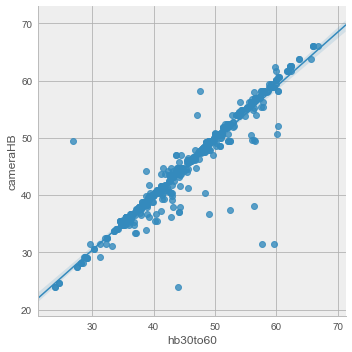

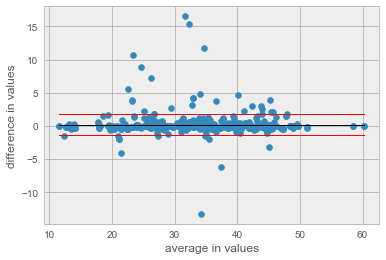

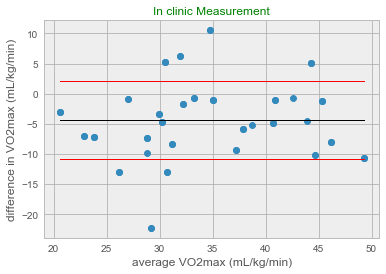

In [238]:
#Merge with Megha's tecumseh and compare
summary = heartbeats.merge(tecumseh, how='outer', left_index= True, right_on='recordId')
summary['cameraMilligan'] = milligan2(summary.cameraHB, summary.age, summary.gender)

#Plot concordance in heartbeats
sns.lmplot('hb30to60', 'cameraHB', data=summary)
hb_concordance = ccc(summary.dropna(subset=['hb30to60', 'cameraHB']).cameraHB, summary.dropna(subset=['hb30to60', 'cameraHB']).hb30to60)
hb_concordance
plt.figure(); plot_bland_altman(summary['cameraMilligan'], summary['vo2Max.Milligan2'])
ccc(summary.dropna(subset=['cameraMilligan', 'vo2Max.Milligan2'])['cameraMilligan'], summary.dropna(subset=['cameraMilligan', 'vo2Max.Milligan2'])['vo2Max.Milligan2'])



#Try to compare to in lab component
df = summary.copy()
df = df.merge(metadata[['externalId', 'Lab Day Wt (kg)', 'Age', 'Sex','Cooper VO2', 
                        'VO2max (mL/kg/min)', 
                        'Step Test HR Beats']], how='left', on='externalId').dropna(subset=['inClinic'])

#3MST in lab from smartphone vs VO2Max
ax = plt.figure()
tmp = df[df.inClinic].dropna(subset=['cameraMilligan','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['cameraMilligan'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='difference in VO2max (mL/kg/min)', xlabel='average VO2max (mL/kg/min)');
print('$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['cameraMilligan']))
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')


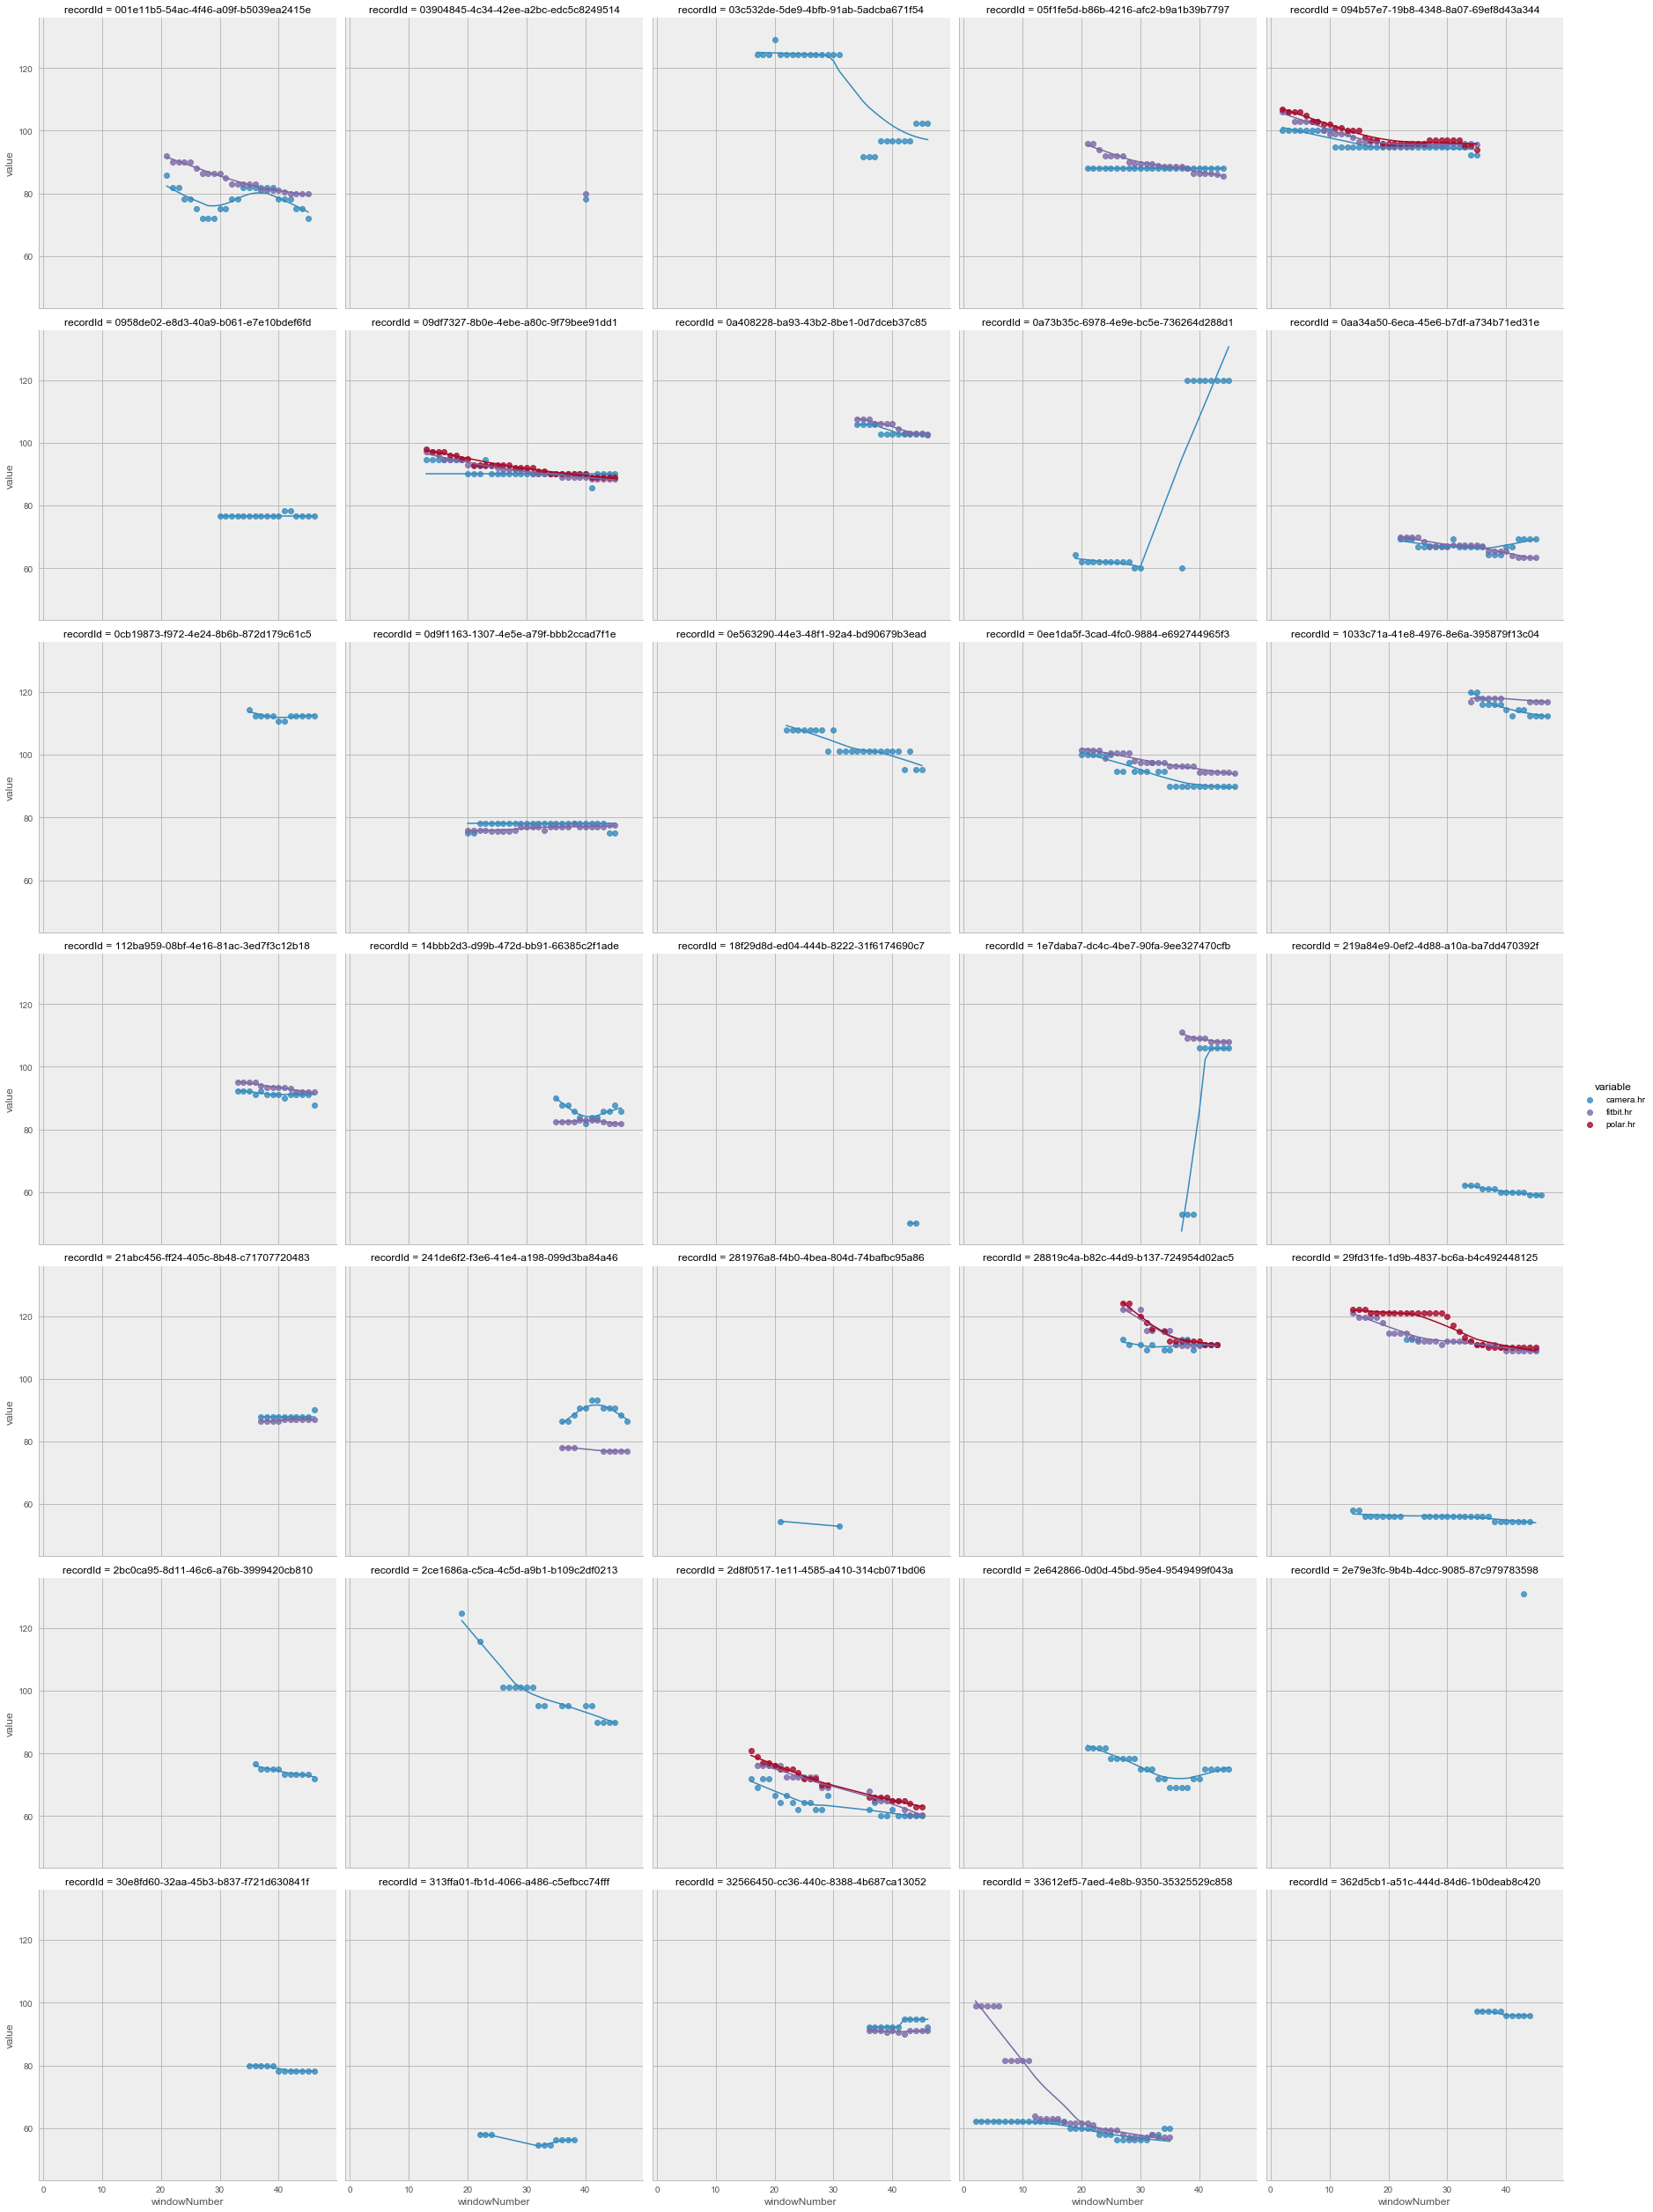

In [164]:
#Plot some example time series of hr
tmp['windowNumber'] = tmp.window.str.replace('Window', '').astype('int')
sns.lmplot(x='windowNumber', y='value',col='recordId', lowess=True, col_wrap=5, hue='variable',
    data = tmp.head(600).melt(['windowNumber', 'recordId'], value_vars=['camera.hr', 'fitbit.hr', 'polar.hr']))

# Table 1

In [18]:
#TODO what happened to the formating e.g. %white and male/female labels.
def percent_white(x):
    return sum(x=='White')/len(x)*100
percent_white.__name__ = '% White'

def sparkline_str(x):
    bins=np.histogram(x, [120,130,140,150,160,170,180,190,200,210])[0]
    avg = np.mean(x)
    sl = ''.join(sparklines.sparklines(bins))+'({0:,.0f})'.format(avg)
    return sl
sparkline_str.__name__ = ""

def sparkline_str_vo2max(x):
    bins=np.histogram(x, [15,20,25,30,35,40,45,50,55,60,65])[0]
    avg = np.mean(x)
    sl = ''.join(sparklines.sparklines(bins))+'({0:,.0f})'.format(avg)
    return sl
sparkline_str.__name__ = ""

def mean_std(x):
    return '{0:,.1f} +/- {1:,.1f}'.format(np.mean(x), np.std(x))
mean_std.__name__ = 'mean +/- std)'

def N_female(x):
    return '{}  ({}|{})'.format(len(x), sum(x=='Female'), sum(x=='Male'))
N_female.__name__ = 'N (F|M)'

format_dict = {'mean':'${0:,0.1f}'}

(metadata.groupby([pd.cut(metadata.Age, pd.np.arange(20, 81, 10))])
     .agg({'Sex': N_female, 
       'Age':mean_std,
       'Ethnicity': percent_white,
       'BMI': mean_std,
       #'Lab Resting HR': 'mean',
       'Max HR':sparkline_str,
       'VO2max (mL/kg/min)': sparkline_str_vo2max})
    .style.format(format_dict))
#.background_gradient(subset=pd.IndexSlice['mean',:], cmap='BuGn'))

# Figure 1

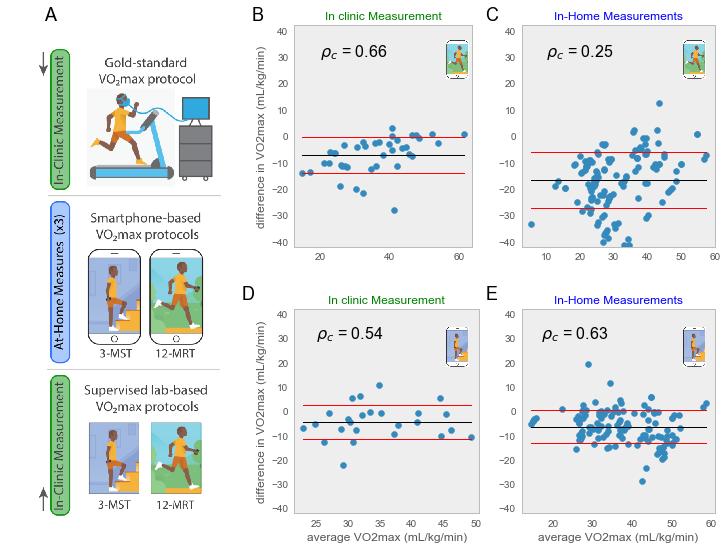

In [19]:
df = df_12mt.copy()
df = df[df['answers.surveyAfter']=='Nothing, was my best effort']
#Merge in true VO2
df = df.merge(metadata[['externalId', 'Age', 'Sex','Cooper VO2', 'VO2max (mL/kg/min)']], how='left', on='externalId')

plt.figure(figsize=(10,10));

#Cooper in lab from smartphone vs VO2Max
ax = plt.subplot(232)
ax.set_position([0.395419, 0.645333, 0.247004, 0.308000])
tmp = df[df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                 ylabel='difference in VO2max (mL/kg/min)', xlabel='');
plt.text(20,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
        fontsize=16,fontname='Arial');
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')
plt.ylim(-42,42);
plt.grid(False);

#Cooper at home from smartphone vs VO2Max
ax=plt.subplot(233);
ax.set_position([0.711225, 0.645333, 0.267941, 0.308000])
tmp = df[~df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='');
plt.text(10,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
        fontsize=16,  fontname='Arial');
plt.title('In-Home Measurements', fontsize=12, fontname='Arial', color= 'Blue')
plt.ylim(-42,42);
plt.grid(False);

# 3 Minute Step test data
df = tecumseh.copy()
df = df.merge(metadata[['externalId', 'Lab Day Wt (kg)', 'Age', 'Sex','Cooper VO2', 
                        'VO2max (mL/kg/min)', 
                        'Step Test HR Beats']], how='left', on='externalId')
#TODO This needs to be the "best HR e.g. highest confidnece between red and green with confidence >0.5"
df = df[df.metric=='camerahr']
atmp =df[['externalId', 'inClinic','vo2Max.Milligan2', 'VO2max (mL/kg/min)', 'os']].dropna().groupby(['externalId', 'inClinic']).mean()

#3MST in lab from smartphone vs VO2Max
ax = plt.subplot(235)
ax.set_position([0.395419, 0.275654, 0.257004, 0.283105])
tmp = df[df.inClinic].dropna(subset=['vo2Max.Milligan2','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['vo2Max.Milligan2'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='difference in VO2max (mL/kg/min)', xlabel='average VO2max (mL/kg/min)');
plt.text(25,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']),
        fontsize=16, fontname='Arial');
plt.title('In clinic Measurement', fontsize=12, fontname='Arial', color= 'Green')
plt.ylim(-42,42);
plt.grid(False);

#3MST in lab from smartphone vs VO2Max
ax = plt.subplot(236)
ax.set_position([0.711225, 0.275654, 0.267941, 0.283105])
tmp = df[~df.inClinic].dropna(subset=['vo2Max.Milligan2','VO2max (mL/kg/min)'])
plot_bland_altman(tmp['vo2Max.Milligan2'], tmp['VO2max (mL/kg/min)'],  
                  ylabel='', xlabel='average VO2max (mL/kg/min)');
plt.text(17,30, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']),
        fontsize=16, fontname='Arial');
plt.title('In-Home Measurements', fontsize=12, fontname='Arial', color= 'Blue')
plt.ylim(-42,42);
plt.grid(False);


#Plot protocol image
ax =  plt.figure(1).add_axes([0.035852, 0.255654, 0.257057, 0.701609]) 
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/protocol.png"))
plt.axis('off');

#Set parameters on Figure and annotate
for ax in plt.figure(1).axes:
    ax.get_xaxis().get_label().set_fontname("Arial")
    ax.get_xaxis().get_label().set_fontsize(12.000000)

plt.figure(1).text(0.047358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.335494, 0.959621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.660518, 0.959621, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.321535, 0.572782, 'D', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.660518, 0.572782, 'E', transform=plt.figure(1).transFigure,fontsize=18, fontname="Arial");

#Add icons 
plt.axes([0.60540, 0.476171, 0.031425, 0.059172])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_3mst.png"))
plt.axis('off');
plt.axes([0.93540, 0.476171, 0.031425, 0.059172])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_3mst.png"))
plt.axis('off');
plt.axes([0.605840, 0.876851, 0.031425, 0.057068])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_cooper.png"))
plt.axis('off');
plt.axes([0.93540, 0.876851, 0.031425, 0.057068])
plt.imshow(plt.imread("/Users/lom/Dropbox/Sage/mobile/crf/manuscript/icon_cooper.png"))
plt.axis('off');

plt.savefig('../manuscript/figure1.pdf');

**Figure 1** Visual abstract and primary results of validation. (A) Visual abstract, participants in the study were randomized into two groups.  The first group performed a gold standard VO2Max protocol and recieved traning on day 1 while the second group performed the two smartphone protocols on day 1, both groups then performed the two protocols at home three times during a two week period before coming back into the clinic to perform the app measures in lab (group 1) or gold standard VO2Max (group 2). B-E show Bland-Altman plots comparing the Gold standard VO2Max with smartphone measures from : B) Cooper run test performed in lab, C) Cooper test at home (up to 3 repeats per participant), D) 3MST in lab, and E) 3MST at home.  For upper limits of performance comparing non-smartphone measures to gold standard see supplemental figures xxx-yy

### Supplemental Figure 1 Ground truth vs lab based tests 
* Cooper vs V02Max from distance measured using track. 
* Tecumseh vs VO2max from heart rate count.
* Effect on Cooper based on self reported effort

Rho_c between Polar chest strap Tecusmeh and ground truth, 0.5367477408055389
Rho_c between Fitbit HR Tecusmeh and ground truth, 0.5370156134317602
Rho_c between Fitbit HR Tecusmeh and ground truth, 0.5354831080758574


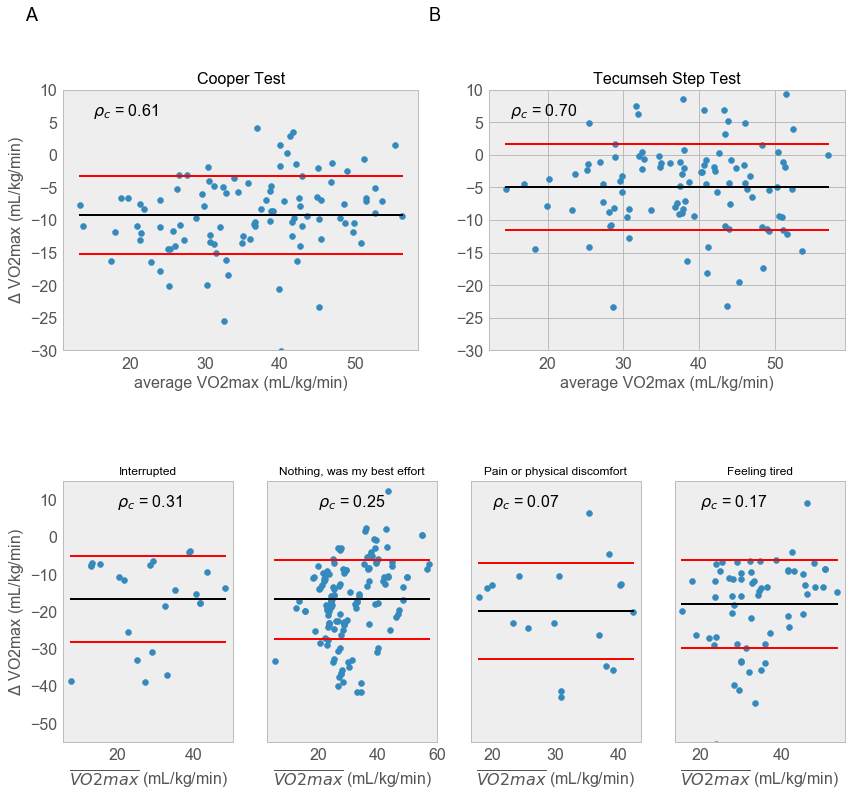

In [53]:
plt.figure(figsize=(14,12));

#Compare  tecumseh from polar, fitbit and camera to ground truth
tmp = tecumseh.query('metric=="polar"  and inClinic==True')[['externalId', 'vo2Max.Milligan2']].merge(metadata, on='externalId').dropna(subset=['vo2Max.Milligan2'])
print('Rho_c between Polar chest strap Tecusmeh and ground truth,',ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']));
tmp = tecumseh.query('metric=="fitbit"  and inClinic==True')[['externalId', 'vo2Max.Milligan2']].merge(metadata, on='externalId').dropna(subset=['vo2Max.Milligan2'])
print('Rho_c between Fitbit HR Tecusmeh and ground truth,',ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']));
tmp = tecumseh.query('metric=="camerahr"  and inClinic==True')[['externalId', 'vo2Max.Milligan2']].merge(metadata, on='externalId').dropna(subset=['vo2Max.Milligan2'])
print('Rho_c between Fitbit HR Tecusmeh and ground truth,',ccc(tmp['VO2max (mL/kg/min)'], tmp['vo2Max.Milligan2']));


# Cooper in lab validation
plt.subplot(2,2,1);
plot_bland_altman(metadata['Cooper VO2'], metadata['VO2max (mL/kg/min)'], 
                  ylabel='$\Delta$ VO2max (mL/kg/min)', xlabel='average VO2max (mL/kg/min)');
plt.text(15,6, '$\\rho_c$ = %0.2f'%ccc(metadata['VO2max (mL/kg/min)'], metadata['Cooper VO2']),
        fontsize=16, fontname='Arial');
plt.ylim(-30,10)
plt.title('Cooper Test', fontsize=16, fontname='Arial');

plt.grid(False);

# Tecumseh in lab validation
plt.subplot(2,2,2);
lab_tecumseh = milligan2(metadata['Step Test HR Beats'].values, metadata['Age'].values, metadata['Sex'].values)
plot_bland_altman(lab_tecumseh, metadata['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='average VO2max (mL/kg/min)');
plt.text(15,6, '$\\rho_c$ = %0.2f'%ccc(metadata['VO2max (mL/kg/min)'], lab_tecumseh),
        fontsize=16, fontname='Arial');
plt.ylim(-30,10)
plt.title('Tecumseh Step Test', fontsize=16, fontname='Arial');


#In Home Cooper as performed by levels of effort
df = df_12mt.copy()
#Merge in true VO2
df = df.merge(metadata[['externalId', 'Age', 'Sex','Cooper VO2', 'VO2max (mL/kg/min)']], how='left', on='externalId')
#df = df[df['answers.surveyAfter']=='Nothing, was my best effort']
df = df[~df.inClinic].dropna(subset=['mobile Cooper','VO2max (mL/kg/min)'])
for i, effort in enumerate(['Interrupted', 'Nothing, was my best effort', 'Pain or physical discomfort', 'Feeling tired']):
    plt.subplot(2,4,5+i)
    tmp = df[df['answers.surveyAfter']==effort]
    plot_bland_altman(tmp['mobile Cooper'], tmp['VO2max (mL/kg/min)'], 
                  ylabel='', xlabel='$\overline{VO2max}$ (mL/kg/min)');
    plt.text(20,8, '$\\rho_c$ = %0.2f'%ccc(tmp['VO2max (mL/kg/min)'], tmp['mobile Cooper']),
            fontsize=16,  fontname='Arial');
    plt.title(effort, fontsize=12, fontname='Arial')
    plt.ylim(-55,15);
    plt.grid(False);
    if i==0:
        plt.ylabel('$\Delta$ VO2max (mL/kg/min)',fontsize=10, fontname='Arial')
    else:
        plt.yticks([])

#Clean up and style plots
for ax in plt.figure(1).axes:
    ax.get_xaxis().get_label().set_fontsize(16.000000);
    ax.get_yaxis().get_label().set_fontsize(16.000000);
    ax.get_xaxis().get_label().set_fontname("Arial");
    ax.get_yaxis().get_label().set_fontname("Arial");
    ax.lines[0].set_linewidth(2.0);
    ax.lines[1].set_linewidth(2.0);
    ax.lines[2].set_linewidth(2.0);
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16);

plt.figure(1).text(0.087358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.487358, 0.959621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
#TODO CALCULATE CONCORDANCE  BETWEEN TRACK DISTANCE AND mobile distance.



plt.savefig('../manuscript/supplemental_figure1.pdf');


#### Supplemental Figure 1
Comparison of in lab performance using standard protocol for a) Cooper 12 minute run test and b) Tecumseh Step Test.  For each plot we are showing the difference between the ground truth VO2Max measurement and measuresments obtained using the distance run around track (for a) and heart rate as measures using finger on pulse measurement (for b).  These distance was also measured using GPS and heart rate was measured using a chest strap and fitbit. The chest strap concordance was 0.54. TODO verify


# Figure 2

In [ ]:
data = (calibration_df.
        query('method=="acf"').
        dropna(subset=['noninHR']))
nSteps=50
nWindows = len(data)
nWindows
confidenceDistributions = pd.DataFrame(np.zeros((nSteps, 3)), columns=['confidence', '% missing', 'concordance'])
        
for i, conf in enumerate(pd.np.arange(0,.9,1/nSteps)):
    #TODO update how we compute HR and confidence e.g. redHR if redConf>greenConf else greenHR then filter
    data = data.assign(hr = lambda x: np.where(x['redConf']>conf, x['redHR'], 
                               np.where(x['greenConf']>conf, x['greenHR'], np.nan)),
                       conf = lambda x: np.where(x['redConf']>conf, x['redConf'], 
                               np.where(x['greenConf']>conf, x['greenConf'], np.nan)))
    confidenceDistributions.loc[i,:]=np.asarray([conf, 
                               (nWindows - sum(data.conf>conf))/nWindows,#/nWindows*100,
                               ccc(data.loc[data.conf>conf, 'hr'], data.loc[data.conf>conf, 'noninHR'])])

plt.subplot(1,2,1)
#TODO update to plot the best confidence not the RedConf
sns.distplot(calibration_df['redConf'].dropna())

plt.subplot(1,2,2)
sns.scatterplot(x='confidence', y='% missing', data=confidenceDistributions);
plt.plot([.5,.5], [0,1], 'r');
plt.title('Confidence cutoffs vs missing data');

**Supplemental Figure X** Distribution of percent of x second windows lost when filtering by different confidence cutoffs.

In [ ]:
confidence_cuttoff=0.5
data = (calibration_df.
        query('method=="acf"').
        dropna(subset=['noninHR']).
        assign(hr = lambda x: np.where(x['redConf']>confidence_cuttoff, x['redHR'], 
                                       np.where(x['greenConf']>confidence_cuttoff, x['greenHR'], np.nan))).
        dropna(subset=['hr']).
        assign(fitzpatrick_group = lambda x: pd.cut(x['face.fitzpatrick'], 
                                                    [1,2,4,6], labels=['1,2', '3,4', '5,6'])))

plt.figure(figsize=(8, 8))
##Figure 2a % error vs skin color wihtout filtering
#TODO verify %error
#TODO add separators for ita cutoffs
#TODO clean up 
#Redo based on interpolation and single measure per person
#TODO color by celeb skintone
ax = plt.subplot(2,1,1);
sns.regplot(x='face.fitzpatrick.ita', y='%error',
           scatter_kws={"s": 2, 'alpha':.5},
           data=data, 
           x_jitter=.5, ax=ax);
#plt.plot([55,55], [-50,100], 'k') #1
plt.plot([41,41], [-50,100], 'k') #2
plt.text(50, 75, '1 and 2')
#plt.plot([28,28], [-50,100], 'k') #3
plt.plot([10,10], [-50,100], 'k') #4
plt.text(20, 75, '3 and 4')
#plt.plot([-30,-30], [-50,100], 'k') #5
plt.text(-15, 75, '5 and 6')



plt.ylim(-50,100);
plt.xlim(-30,65);
#plt.subplot(2,3,3)
#sns.distplot(data['%error'].dropna(), vertical=True)

##Figure 2b %confidence vs missing data
ax = plt.subplot(2,2,3)
sns.scatterplot(x='confidence', y='concordance', data=confidenceDistributions)
plt.ylim([.8,1])
plt.plot([.5,.5], [.8,1], 'r')

##Figure 2c - heatmap
# TODO - redo single measure per person and interpolation
ax = plt.axes([0.743116, 0.110000, 0.156884, 0.308000])
c = data.groupby(['phone', 'fitzpatrick_group']).apply(lambda d: ccc(d['hr'],d['noninHR'])).unstack('fitzpatrick_group', 'phone')
sns.heatmap(c, annot=True,cbar=False, cmap="YlGnBu") #cbar_kws={'min':0, 'max':1});
plt.ylabel('')

plt.figure(1).text(0.087358, 0.959621, 'A', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.087358, 0.459621, 'B', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");
plt.figure(1).text(0.587358, 0.459621, 'C', transform=plt.figure(1).transFigure, fontsize=18, fontname="Arial");

plt.xlabel('Fitzpatrick skin type');

plt.savefig('../manuscript/figure2.pdf');



**Figure 2**: Some text

### Supplemental Figure for HR validation against Polar and fitbit

In [ ]:
plt.figure(figsize=(15,5))
df = df_hr.dropna(subset=['polar.hr', 'hr', 'fitbit.hr'])
ax=plt.subplot(1,3,1);
plot_bland_altman(df['polar.hr'], df['hr'], c=df['conf'], ylabel='%s - %s [beats/min]'%('polar HR', 'camera HR'))
x=plt.title('$\\rho_c$ = %0.2f' %ccc(df['polar.hr'], df['hr']));
plt.ylim(-20,80);

#df = df_hr.dropna(subset=['fitbit.hr', 'hr'])
ax=plt.subplot(1,3,2);
plot_bland_altman(df['fitbit.hr'], df['hr'], c=df['conf'], ylabel='%s - %s [beats/min]'%('fitbit HR', 'camera HR'))
x=plt.title('$\\rho_c$ = %0.2f' %ccc(df['fitbit.hr'], df['hr']));
plt.ylim(-20,80);


#df = df_hr.dropna(subset=['fitbit.hr', 'polar.hr'])
ax=plt.subplot(1,3,3);
plot_bland_altman(df['fitbit.hr'], df['polar.hr'], ylabel='%s - %s [beats/min]'%('fitbit HR', 'polar HR'))
x=plt.title('$\\rho_c$ = %0.2f' %ccc(df['fitbit.hr'], df['polar.hr']));
plt.subplots_adjust(wspace=.25, hspace=.15);
plt.yticks()
plt.ylim(-20,80);


In [96]:
tecumesh.head()


Unnamed: 0    metric   hb15to30    conf15   hb30to60    conf30  \
0           1      blue  21.883117  0.627501  39.393800  0.611277   
1          91  camerahr  22.790630  0.676223  39.824591  0.623605   
2         181    fitbit  23.375000       NaN  42.975000       NaN   
3         271     green  23.145933  0.625136  39.377011  0.596510   
4         361     polar        NaN       NaN        NaN       NaN   

                               recordId externalId  age gender  weight  \
0  001e11b5-54ac-4f46-a09f-b5039ea2415e     PMI133   28   Male    78.2   
1  001e11b5-54ac-4f46-a09f-b5039ea2415e     PMI133   28   Male    78.2   
2  001e11b5-54ac-4f46-a09f-b5039ea2415e     PMI133   28   Male    78.2   
3  001e11b5-54ac-4f46-a09f-b5039ea2415e     PMI133   28   Male    78.2   
4  001e11b5-54ac-4f46-a09f-b5039ea2415e     PMI133   28   Male    78.2   

   vo2Max.Milligan1  vo2Max.Milligan2  vo2Max.Shakey createdDate  inClinic  \
0         45.520676         49.080233      17.988541  2018-07-11     False   
1         45.209645         48.827790      17.385382  2018-07-11     False   
2         42.935050         46.981650      17.017949  2018-07-11     False   
3         45.532798         49.090071      17.160113  2018-07-11     False   
4               NaN               NaN            NaN  2018-07-11     False   

    os appVersion  
0  NaN        NaN  
1  NaN        NaN  
2  NaN        NaN  
3  NaN        NaN  
4  NaN        NaN

In [14]:

#from pandas_profiling import ProfileReport
#profile = ProfileReport(df_hr, title='HR summary')
#profile.to_notebook_iframe()

#df_hr.columns
#df_hr.shape
#df_hr.dropna(subset=['polar.hr']).
#      originalTable)
#data = (calibration_df.
#        query('method=="acf"').
#        dropna(subset=['noninHR']).
#        assign(hr = lambda x: np.where(x['redConf']>confidence_cuttoff, x['redHR'], 
#                                       np.where(x['greenConf']>confidence_cuttoff, x['greenHR'], np.nan))).
#        dropna(subset=['hr']).
#        assign(fitzpatrick_group = lambda x: pd.cut(x['face.fitzpatrick'], 
#                                                    [1,2,4,6], labels=['1,2', '3,4', '5,6'])))

syn.store('oath', executed = thisCodeInGithub())